# Analysis notebook

In [1]:
from mdtraj import density
import mdtraj as mdt
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("seaborn")
plt.style.use("tex")

figdir = "figures/"

In [2]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [3]:
# Active residues
act_chain_a = [92,93,95,98,171,172,173,180,181,182,221,226,227,228,310, "EFZ"]
act_chain_a_names = ["LEU","LYS","LYS","VAL","VAL","ILE","TYR","TYR","VAL","GLY","TRP","LEU","HIS","PRO","TYR"]
act_chain_b = [648-520+1, "EFZ"]
act_chain_b_names = ["GLU"]


In [4]:
gofr_chain_a_efz = [] 
for res in act_chain_a:
    gofr_chain_a_efz.append(np.genfromtxt(f"src/res/chain_a_md/gofr_{res}.dat"))

gofr_chain_a_efz = np.array(gofr_chain_a_efz) 

gofr_chain_b_efz = [] 
for res in act_chain_b:
    gofr_chain_b_efz.append(np.genfromtxt(f"src/res/chain_b_md/gofr_{res}.dat"))

gofr_chain_b_efz = np.array(gofr_chain_b_efz) 


In [5]:
sel_a = ""
for i,res in enumerate(act_chain_a[:-1]):
    sel_a = sel_a +f"resid {res}"
    if i!=len(act_chain_a)-2:
        sel_a+=" or "

In [6]:
chain_a_traj = mdt.load("src/res/chain_a_efz_solv_box_md.nc",top="src/res/chain_a_efz_solv_box.prmtop")
chain_b_traj = mdt.load("src/res/chain_b_efz_solv_box_md.nc",top="src/res/chain_b_efz_solv_box.prmtop")

prot_a = chain_a_traj.atom_slice(chain_a_traj.topology.select("protein"))
prot_b = chain_b_traj.atom_slice(chain_b_traj.topology.select("protein"))

efz_a = chain_a_traj.atom_slice(chain_a_traj.topology.select("resname EFZ"))
efz_b = chain_b_traj.atom_slice(chain_b_traj.topology.select("resname EFZ"))

efz_a = chain_a_traj.atom_slice(chain_a_traj.topology.select("resname EFZ"))
efz_b = chain_b_traj.atom_slice(chain_b_traj.topology.select("resname EFZ"))

act_site_a = chain_a_traj.atom_slice(chain_a_traj.topology.select(sel_a))
avg_dens_a = density(chain_a_traj.atom_slice(chain_a_traj.topology.select("resname HOH"))).mean()
avg_dens_b = density(chain_b_traj.atom_slice(chain_b_traj.topology.select("resname HOH"))).mean()

## Radial distribution function and coordination number

In [8]:
cnum_chain_a_efz = gofr_chain_a_efz.copy()
cnum_chain_a_efz[:,:,1] = 4*np.pi*avg_dens_a*cnum_chain_a_efz[:,:,1]*cnum_chain_a_efz[:,:,0]**2

temp = cumtrapz(gofr_chain_a_efz[:,:,1],gofr_chain_a_efz[:,:,0])
cnum_chain_a_efz = cnum_chain_a_efz[:,1:,:] - cnum_chain_a_efz[:,:1,:]
cnum_chain_a_efz[:,:,1] = temp

In [9]:
cnum_chain_b_efz = gofr_chain_b_efz.copy()
cnum_chain_b_efz[:,:,1] = 4*np.pi*avg_dens_b*cnum_chain_b_efz[:,:,1]*cnum_chain_b_efz[:,:,0]**2

temp = cumtrapz(gofr_chain_b_efz[:,:,1],gofr_chain_b_efz[:,:,0])
cnum_chain_b_efz = cnum_chain_b_efz[:,1:,:] - cnum_chain_b_efz[:,:1,:]
cnum_chain_b_efz[:,:,1] = temp

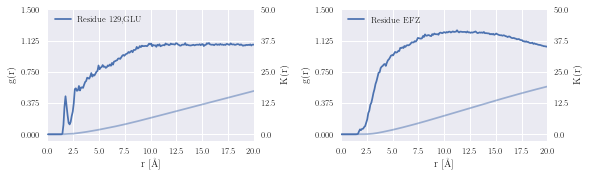

In [78]:
fig, axes = plt.subplots(1,2, figsize=set_size(600,subplots=(1,2)))
axes = np.array(axes)
plt.xlabel("r")
plt.xlim([0,20])
for i, (ax,res,res2) in enumerate(zip(axes.flatten(),gofr_chain_b_efz,cnum_chain_b_efz)):
    ax.set_xlim([0,20])
    ax2 = ax.twinx()

    ax.set_ylim([-0.075,1.5])
    ax2.set_ylim([-2.5,50])
    ax.set_yticks(np.linspace(0,1.5,5))
    ax2.set_yticks(np.linspace(0,50,5))

    if act_chain_b[i]=="EFZ":
        ax.plot(res[:,0], res[:,1], label = f"Residue {act_chain_b[i]}" )
    else:
        ax.plot(res[:,0], res[:,1], label = f"Residue {act_chain_b[i]},{act_chain_b_names[i]}" )
    
    ax2.plot(res2[:,0], res2[:,1], alpha=0.5)

    ax.set_xlabel(r"r [\AA]")
    ax.set_ylabel("g(r)")
    ax2.set_ylabel("K(r)")

    ax2.grid(None)
    ax.legend(loc=2)

plt.tight_layout()
plt.savefig(figdir+"b_chain_act.pdf")

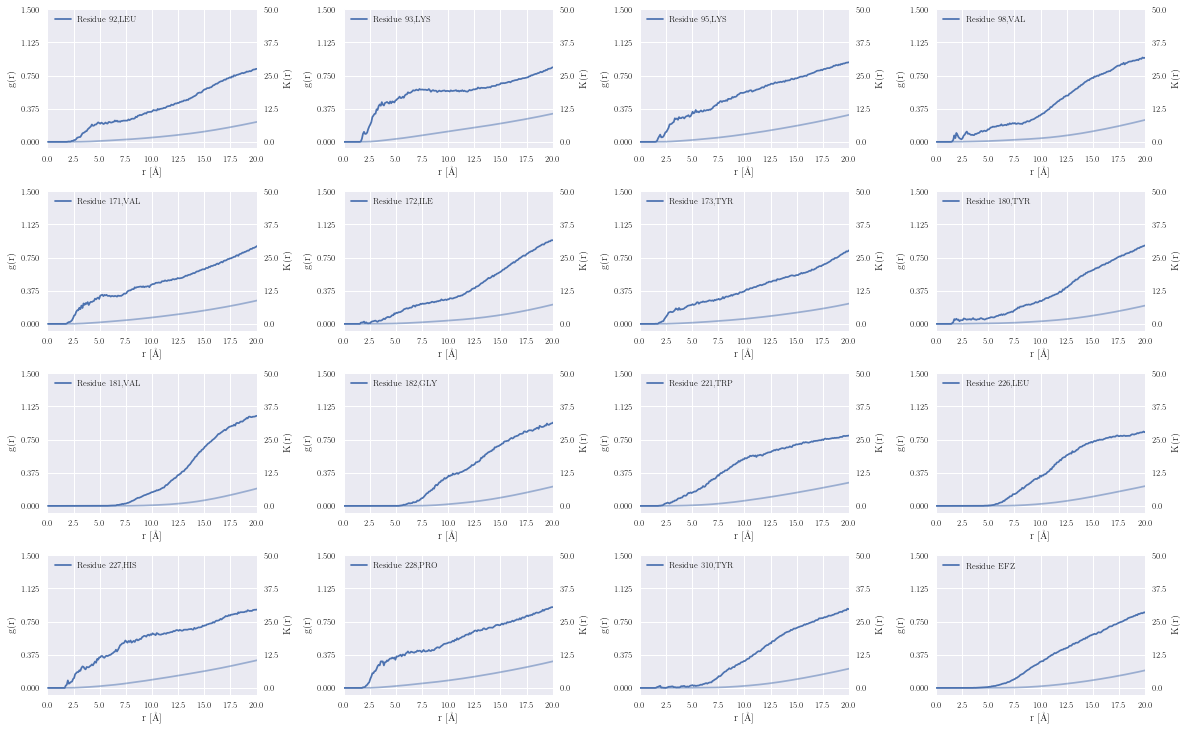

In [79]:
fig, axes = plt.subplots(4,4, figsize=set_size(1200,subplots=(4,4)))
axes = np.array(axes)
plt.xlabel("r")
for i, (ax,res,res2) in enumerate(zip(axes.flatten(),gofr_chain_a_efz,cnum_chain_a_efz)):
    ax.set_xlim([0,20])

    ax2 = ax.twinx()

    ax.set_ylim([-0.075,1.5])
    ax2.set_ylim([-2.5,50])
    ax.set_yticks(np.linspace(0,1.5,5))
    ax2.set_yticks(np.linspace(0,50,5))

    if act_chain_a[i]=="EFZ":
        ax.plot(res[:,0], res[:,1], label = f"Residue {act_chain_a[i]}" )
    else:
        ax.plot(res[:,0], res[:,1], label = f"Residue {act_chain_a[i]},{act_chain_a_names[i]}" )
    
    ax2.plot(res2[:,0], res2[:,1], alpha=0.5)

    ax.set_xlabel(r"r [\AA]")
    ax.set_ylabel("g(r)")
    ax2.set_ylabel("K(r)")

    ax2.grid(None)

    ax.legend(loc=2)

plt.tight_layout()
plt.savefig(figdir+"a_chain_act.pdf")

## RMSD

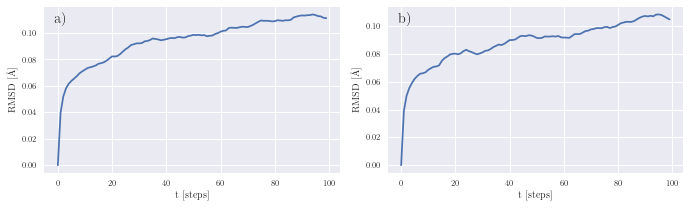

In [32]:
fig, axes = plt.subplots(1,2, figsize=set_size(700,subplots=(1,2)))

import matplotlib.transforms as mtransforms
for label, ax in zip(["a)","b)"],axes):
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='x-large', verticalalignment='top',fontweight="black",
            )


axes = np.array(axes)
axes[0].set_xlabel("t [steps]")
axes[0].set_ylabel(r"RMSD [\AA]")

axes[1].set_xlabel("t [steps]")
axes[1].set_ylabel(r"RMSD [\AA]")

axes[0].plot(mdt.rmsd(prot_a,prot_a))
axes[1].plot(mdt.rmsd(prot_b,prot_b))

plt.tight_layout()
plt.savefig(figdir+"rmsd.pdf")

## RMSF

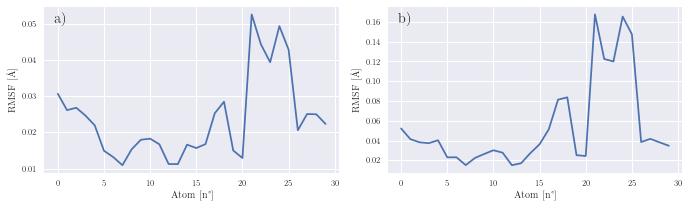

In [33]:
fig, axes = plt.subplots(1,2, figsize=set_size(700,subplots=(1,2)))
axes = np.array(axes)

import matplotlib.transforms as mtransforms
for label, ax in zip(["a)","b)"],axes):
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='x-large', verticalalignment='top',fontweight="black",
            )


axes[0].set_xlabel("Atom [n°]")
axes[0].set_ylabel(r"RMSF [\AA]")

axes[1].set_xlabel("Atom [n°]")
axes[1].set_ylabel(r"RMSF [\AA]")

axes[0].plot(mdt.rmsf(efz_a,efz_a))
axes[1].plot(mdt.rmsf(efz_b,efz_b))

plt.tight_layout()
plt.savefig(figdir+"rmsf_efz.pdf")


In [34]:
max_rmsf = np.argsort(mdt.rmsf(efz_b,efz_b), )[-8:].astype(int)
atom_list = np.array([atom for atom in efz_a.topology.atoms])
atom_list[list(max_rmsf)]

array([EFZ520-CL, EFZ520-C11, EFZ520-C12, EFZ520-H112, EFZ520-H121,
       EFZ520-H101, EFZ520-H111, EFZ520-H122], dtype=object)

## Distance from active site

In [35]:
com_site_a = mdt.compute_center_of_mass(act_site_a)
com_sites_a = mdt.compute_center_of_mass(chain_a_traj.atom_slice(chain_a_traj.topology.select(f"resname EFZ")))
act_site_distance_a = np.linalg.norm(com_sites_a-com_site_a,axis=1)

mdt_res_b = mdt.compute_center_of_mass(chain_b_traj.atom_slice(chain_b_traj.topology.select(f"resid {act_chain_b[0]}")))
mdt_efz_b = mdt.compute_center_of_mass(chain_b_traj.atom_slice(chain_b_traj.topology.select(f"resname {act_chain_b[1]}")))

act_site_distance_b = np.linalg.norm(mdt_efz_b-mdt_res_b,axis=1)

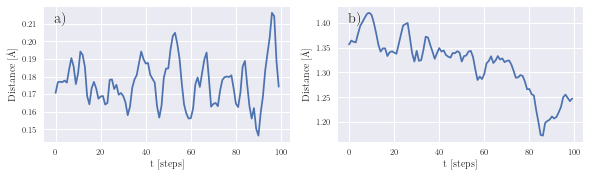

In [36]:
fig, axes = plt.subplots(1,2, figsize=set_size(600,subplots=(1,2)))

import matplotlib.transforms as mtransforms
for label, ax in zip(["a)","b)"],axes):
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='x-large', verticalalignment='top',fontweight="black",
            )


axes[0].set_xlabel("t [steps]")
axes[0].set_ylabel(r"Distance [\AA]")
axes[1].set_xlabel("t [steps]")
axes[1].set_ylabel(r"Distance [\AA]")

axes[0].plot(act_site_distance_a, label = f"Residue EFZ" )
    

axes[1].plot(act_site_distance_b, label = f"Residue EFZ" )


plt.tight_layout()
plt.savefig(figdir+"dis_chain_act.pdf")